## Handle Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import os

## Config Variables

In [2]:
BASE_IMG_DIR = "data/"

EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224
LR = 5e-2

RANDOM_SEED = 42

TEST_SPLIT = 0.2

In [3]:
def info(msg):
    print(f"[INFO] {msg}\n")

In [4]:
df = pd.read_excel("Stroke _DCM _Train_Labels.xlsx")

## Remove unneeded rows and rename columns

In [5]:
# Drop second row and last row
df.drop(index=df.index[-1], axis=0, inplace=True)
df.drop(index=df.index[0], axis=0, inplace=True)

In [6]:
df.rename(columns = {'SERIES': "Positive", "Unnamed: 4": "TP", "Unnamed: 5": "Negative"}, inplace = True)

In [7]:
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,26 to 44,19,31
2,2,STP22,50.0,26 to 46,21,29
3,3,STP23,50.0,26 to 42,17,33
4,4,STP24,50.0,26 to 46,21,29
5,5,STP25,50.0,26 to 45,20,30


## Create functions to generate image ranges for the data frame

In [8]:
def resolve_to_range(txt):
    txt = txt.split(",")
    _l = []
    
    for i in txt:
        a, b = [int(v) for v in i.split("to")]
        
        for j in range(a, b+1):
            _l.append(j)
            
    return _l

def sort_key(name):
    parts = name.split('.')
    keys = []
    for part in parts:
        if part.isdigit():
            keys.append(int(part))
        else:
            keys.append(part)
    return tuple(keys)
    
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

## Convert Positive column to have individual positive numbers

In [9]:
df.Positive = df.Positive.apply(resolve_to_range)
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",19,31
2,2,STP22,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
3,3,STP23,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",17,33
4,4,STP24,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
5,5,STP25,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",20,30


## Create new DataFrame holding the ImageWise Data

In [13]:
dataset = {"Images": [], "Tumour": []}

for i in range(1, df.shape[0]+1):
    fn = df["IMAGE NAME"][i]
    pos_l = df.Positive[i]
    
    files = os.listdir(BASE_IMG_DIR + fn + " " + fn + "/" + "STUDY/")
#     files = sorted(files, key=sort_key)
#     print(files)
    
    for index, f in enumerate(files):
        dataset["Images"].append(f"{BASE_IMG_DIR}{fn} {fn}/STUDY/{f}")
        if index+1 in pos_l:
            dataset["Tumour"].append(1)
        else:
            dataset["Tumour"].append(0)

info("Total No. of Positive Samples: " + str(dataset["Tumour"].count(1)))
info("Total No. of Negative Samples: " + str(dataset["Tumour"].count(0)))

class_weights = {0: 1.0, 1: 3192/2108}
print(class_weights)

[INFO] Total No. of Positive Samples: 2110

[INFO] Total No. of Negative Samples: 3190

{0: 1.0, 1: 1.5142314990512333}


## Load the cleaned data into a new DataFrame

In [14]:
data_df = pd.DataFrame(dataset)
data_df.head()
data_df.to_csv("updated2.csv")

## Load the images and convert them into a Numpy array

In [16]:
image_data = []
target = np.array(data_df.Tumour)

In [17]:
for fn in data_df.Images:
    image = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.reshape(image.shape[0], image.shape[1], 1)
    
    image_data.append(image)
    
image_data = np.array(image_data)

## Plot random images

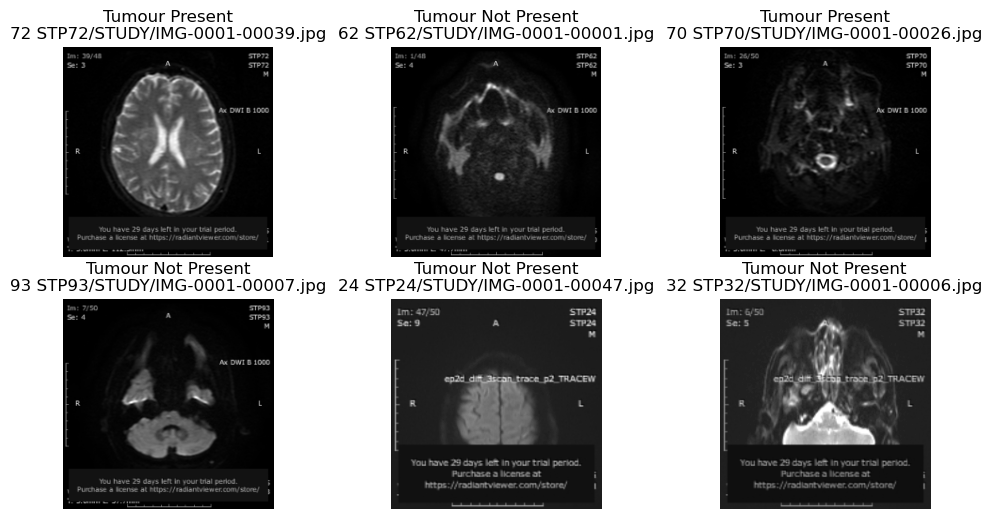

In [18]:
random_indexes = random.sample(range(len(image_data)), k=6)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for (idx, c_ax) in zip(random_indexes, axs.flatten()):
    c_ax.imshow(image_data[idx], cmap="gray")
    if target[idx] == 1:
        title = "Tumour Present"
    else:
        title = "Tumour Not Present"
    c_ax.set_title(title + "\n" + str(data_df.Images[idx]).replace("data/STP", ""))
    c_ax.axis("off")

In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    stratify=target)

## Create Data Augumentation

In [21]:
train_aug = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

test_aug = ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_gen = test_aug.flow(X_test, y_test, batch_size=BATCH_SIZE)

training_steps_per_epoch = train_gen.n // BATCH_SIZE
test_steps_per_epoch = test_gen.n // BATCH_SIZE

info(f"Training Steps per Epoch: {training_steps_per_epoch}")
info(f"Test Steps per Epoch: {test_steps_per_epoch}")

[INFO] Training Steps per Epoch: 132

[INFO] Test Steps per Epoch: 33



## Initialise the model

In [92]:
def create_model():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Conv2D(512, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(512, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        
        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

model = create_model()

In [93]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=[f1_score, "accuracy"],
              loss="binary_crossentropy")

In [94]:
save_best = tf.keras.callbacks.ModelCheckpoint(f"model_brainstroke.h5",
                                               monitor="val_f1_score",
                                               mode="max",
                                               save_best_only=True,
                                               verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score",
                                                  mode="max",
                                                  patience=10)

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=training_steps_per_epoch,
                    validation_data=test_gen,
                    validation_steps=test_steps_per_epoch,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[save_best, early_stopping])

In [42]:
model = tf.keras.models.load_model("model_brainstroke_big.h5", compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=[f1_score, "accuracy"],
              loss="binary_crossentropy")

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Test Loss"], loc="upper right")
plt.show()

In [43]:
pred = model.predict(test_gen, verbose=1)
pred

34/34 [==============================] - 127s 4s/step


array([[0.5325585 ],
       [0.5341645 ],
       [0.28490505],
       ...,
       [0.53266037],
       [0.49023202],
       [0.51681936]], dtype=float32)

In [44]:
metrics.f1_score(y_test, np.round(pred))

0.5187713310580204

In [34]:
metrics.confusion_matrix(y_test, np.round(pred))

array([[185, 453],
       [125, 297]], dtype=int64)

In [45]:
results = {"SN": [], "Label": []}
for f in os.listdir("test"):
    image = cv2.imread("test/" + f, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    image = image/255.0

    b = np.expand_dims(image, axis=0)
    v = model.predict(b)[0]
    results["SN"].append(int(f.replace(".jpg", "")))
    results["Label"].append(int(np.round(v)))

1/1 [==============================] - 0s 200ms/step


In [36]:
result_df = pd.DataFrame(results)
result_df = result_df.sort_values("SN")
result_df.head()

,SN,Label
0,1,1
12,2,1
23,3,1
34,4,1
45,5,1
